Step 1: Import necessary libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import ShuffleSplit,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import joblib


Step 2: Load the dataset

In [ ]:
df = pd.read_csv('../ml_model_dataset/menstrual_cycle_dataset_big.csv')
df.head()

,age,cycle_length,period_duration,flow_intensity,pms_symptoms_score,spotting_between,stress_level,is_abnormal
0,26,28,5,0,10,0,0,0
1,42,40,6,1,5,1,6,1
2,21,15,7,1,6,0,9,1
3,25,30,6,1,5,0,5,0
4,41,33,1,1,8,0,10,1


In [ ]:
df.shape

(2000, 8)

 Step 3: Check for missing values

In [ ]:
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 age                   0
cycle_length          0
period_duration       0
flow_intensity        0
pms_symptoms_score    0
spotting_between      0
stress_level          0
is_abnormal           0
dtype: int64


Step 4: Separate features (X) and target (y)

In [ ]:
X = df.drop("is_abnormal", axis=1)  # All columns except the label
y = df["is_abnormal"]               # Target: 0 = normal, 1 = abnormal

In [ ]:
X.head()

,age,cycle_length,period_duration,flow_intensity,pms_symptoms_score,spotting_between,stress_level
0,26,28,5,0,10,0,0
1,42,40,6,1,5,1,6
2,21,15,7,1,6,0,9
3,25,30,6,1,5,0,5
4,41,33,1,1,8,0,10


In [ ]:
y.head()

0    0
1    1
2    1
3    0
4    1
Name: is_abnormal, dtype: int64

### Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (1600, 7)
Testing set size: (400, 7)


### Feature Scalling

In [ ]:
scaler = StandardScaler()

# Fit on training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Show a sample of the scaled features
print("Sample of scaled training data:")
print(X_train_scaled[:5])


Sample of scaled training data:
[[-0.90344125  0.36181146  1.26053946 -0.00450766  1.58702004 -0.42521972
  -0.62111746]
 [ 1.28476907  0.50877727 -0.26854555  1.43794389  1.58702004 -0.42521972
  -0.30064408]
 [-1.54703252 -1.4017783   0.24114945 -0.00450766 -0.60629492 -0.42521972
   0.66077604]
 [ 1.67092384  1.53753797 -0.26854555 -1.44695921  1.58702004 -0.42521972
   1.30172279]
 [-1.28959601  0.94967471  1.26053946 -0.00450766 -1.23295634 -0.42521972
  -1.26206421]]


### Model Comparison

In [ ]:
def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'logistic_regression': {
            'model': LogisticRegression(max_iter=100),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'decision_tree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'criterion': ['entropy', 'gini', 'log_loss'],
                'splitter': ['best', 'random'],
                'max_depth': [None, 5, 10] 
            }
        },
        'random_forest': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [10, 50, 100],
                'criterion': ['gini', 'entropy', 'log_loss'],
                'max_depth': [None, 5, 10]
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_macro',
        'recall': 'recall_macro',
        'f1': 'f1_macro'
    }
    
    for algo_name, config in algos.items():
        gs = GridSearchCV(
            config['model'], 
            config['params'], 
            cv=cv, 
            scoring=scoring, 
            refit='accuracy', 
            return_train_score=False
        )
        gs.fit(X, y)

        best_index = gs.best_index_

        scores.append({
            'model': algo_name,
            'best_params': gs.best_params_,
            'accuracy': gs.cv_results_['mean_test_accuracy'][best_index],
            'precision': gs.cv_results_['mean_test_precision'][best_index],
            'recall': gs.cv_results_['mean_test_recall'][best_index],
            'f1': gs.cv_results_['mean_test_f1'][best_index]
        })

    return pd.DataFrame(scores, columns=['model', 'best_params', 'accuracy', 'precision', 'recall', 'f1'])


In [ ]:
score_parameters = find_best_model_using_gridsearchcv(X,y)

/home/prasad-nirmal/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
score_parameters

,model,best_params,accuracy,precision,recall,f1
0,logistic_regression,{'fit_intercept': True},0.6215,0.624326,0.587263,0.569370
1,decision_tree,"{'criterion': 'log_loss', 'max_depth': 10, 'sp...",0.9210,0.925431,0.914796,0.918658
2,random_forest,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",0.9485,0.949380,0.945786,0.947341


In [ ]:
score_parameters.best_params[2]

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}

## According to the comparison we can choose RandomForestClassifier as our Model with best parameters :
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}

### Model Building

In [ ]:
model = RandomForestClassifier(criterion='gini',max_depth=10,n_estimators=100)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, n_estimators=50)

### Model Evaluation

In [ ]:
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {acc:.2f}")
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()


Accuracy on test set: 0.96


In [ ]:
def table_report(df_report):
    plt.figure(figsize=(8, 3))
    ax = plt.gca()
    ax.axis('off')

    table = plt.table(cellText=df_report.round(2).values,
                    colLabels=df_report.columns,
                    rowLabels=df_report.index,
                    loc='center',
                    cellLoc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.title("Classification Report", fontsize=14)
    plt.show()

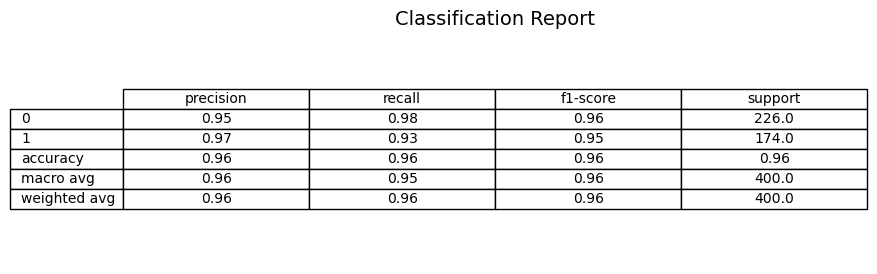

In [ ]:
table_report(df_report)

### Save wanted files

In [ ]:
# Save model
joblib.dump(model, '../ml_model/random_forest_model.joblib')
# Save scaler
joblib.dump(scaler, '../ml_model/scaler.joblib')


['../ml_model/scaler.joblib']

### Load model and scaler for testing

In [ ]:
# Load model and scaler
loaded_model = joblib.load('../ml_model/random_forest_model.joblib')
loaded_scaler = joblib.load('../ml_model/scaler.joblib')

# Sample input: age=30, cycle_length=27, period_duration=5, flow_intensity=1, pms_symptoms_score=4, spotting_between=0, stress_level=3
new_data = np.array([[30, 27, 5, 1, 4, 0, 3]])

# Scale the input features
new_data_scaled = loaded_scaler.transform(new_data)

# Predict
prediction = loaded_model.predict(new_data_scaled)

print("Prediction (0=Normal, 1=Abnormal):", prediction[0])


Prediction (0=Normal, 1=Abnormal): 0


/home/prasad-nirmal/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Try different inputs

In [ ]:
# Function to test input and print prediction
def test_cycle_input(age, cycle_length, period_duration, flow_intensity, pms_symptoms_score, spotting_between, stress_level):
    input_data = np.array([[age, cycle_length, period_duration, flow_intensity, pms_symptoms_score, spotting_between, stress_level]])
    input_scaled = loaded_scaler.transform(input_data)
    pred = loaded_model.predict(input_scaled)[0]
    label = "Abnormal" if pred == 1 else "Normal"
    print(f"Input: {input_data.flatten()}")
    print(f"Prediction: {label}\n")

# Examples to try
test_cycle_input(30, 27, 5, 1, 4, 0, 3)  # Expected: Normal
test_cycle_input(22, 40, 6, 2, 8, 1, 9)  # Expected: Abnormal (long cycle, heavy flow, spotting, high stress)
test_cycle_input(28, 19, 4, 0, 2, 0, 2)  # Expected: Abnormal (short cycle)
test_cycle_input(35, 30, 9, 1, 6, 0, 4)  # Expected: Abnormal (long period duration)


Input: [30 27  5  1  4  0  3]
Prediction: Normal

Input: [22 40  6  2  8  1  9]
Prediction: Abnormal

Input: [28 19  4  0  2  0  2]
Prediction: Abnormal

Input: [35 30  9  1  6  0  4]
Prediction: Abnormal



/home/prasad-nirmal/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/prasad-nirmal/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/prasad-nirmal/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/prasad-nirmal/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Interactive input + prediction code (for testing)

In [ ]:
# # Make sure you have loaded your model and scaler as before

# def get_user_input_and_predict():
#     print("Enter menstrual cycle data:")
#     age = int(input("Age (years): "))
#     cycle_length = int(input("Cycle length (days): "))
#     period_duration = int(input("Period duration (days): "))
#     flow_intensity = int(input("Flow intensity (0=Light,1=Medium,2=Heavy): "))
#     pms_symptoms_score = int(input("PMS symptoms score (0-10): "))
#     spotting_between = int(input("Spotting between periods? (0=No, 1=Yes): "))
#     stress_level = int(input("Stress level (0-10): "))

#     # Create numpy array and scale
#     input_data = np.array([[age, cycle_length, period_duration, flow_intensity, pms_symptoms_score, spotting_between, stress_level]])
#     input_scaled = loaded_scaler.transform(input_data)

#     # Predict
#     pred = loaded_model.predict(input_scaled)[0]
#     label = "Abnormal" if pred == 1 else "Normal"

#     print(f"\nPrediction: Your menstrual cycle is likely: {label}")

# # Call the function
# get_user_input_and_predict()
